TODO: continue with the `hoggorm` package to compute the RV coeffs.

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import typing
from typing import Any, Dict, List, Optional
from typeguard import typechecked
import pickle
import argparse
import scipy
from utils.utils_IO import save_object, load_object, set_or_open_folder
from utils.kinematics import compute_speed, compute_accel
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import hoggorm as ho # library for multivariate stats

ImportError: cannot import name 'set_or_open_folder' from 'utils.utils_IO' (/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/mormyrid-control/mrmrd_ctrl/utils/utils_IO.py)

In [217]:
@typechecked
def set_or_open_folder(folder_path: str) -> str:
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path, exist_ok=True)
        print("Opened a new folder at: {}".format(folder_path))
    else:
        print("The folder already exists at: {}".format(folder_path))
    return folder_path

In [3]:
data_dict = load_object('/Volumes/sawtell-locker/C1/free/3d_reconstruction/V2/data_dict')

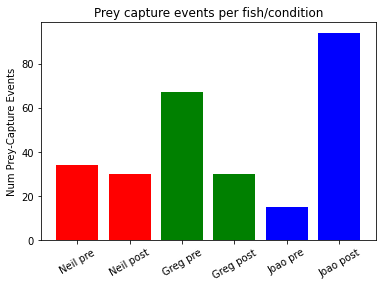

In [4]:
count = 0
color_list = ['r', 'g', 'b']
xlabel_list = []
for i, name in enumerate(data_dict["inds"].keys()):
    for j, cond in enumerate(data_dict["inds"][name].keys()):
        plt.bar(count, len(data_dict["inds"][name][cond]), color = color_list[i])
        count+=1
        xlabel_list.append(name + ' ' + cond)
plt.xticks(ticks=np.arange(count), labels = xlabel_list, rotation=30);
plt.ylabel("Num Prey-Capture Events");
plt.title('Prey capture events per fish/condition');

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
def plot_participation_ratio(pca_object=None, ax = None, plot_folder=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(np.arange(1,len(pca_object.explained_variance_ratio_)+1),
             np.cumsum(pca_object.explained_variance_ratio_))
    ax.grid()
    ax.set_ylabel('frac. explained var.')
    ax.set_xlabel('# components')
    ax.set_xticks(np.arange(1,len(pca_object.explained_variance_ratio_)+1))
    ax.set_title('PCA participation ratio')
    return ax

In [5]:
def plot_correlation_heatmap(corr_mat: pd.core.frame.DataFrame, labels: list[str])-> None:
    plt.imshow(corr_mat)
    plt.xticks(ticks = np.arange(0, corr_mat.shape[-1], 3), labels =  labels, rotation=40);
    plt.yticks(ticks = np.arange(0, corr_mat.shape[-1], 3), labels =  labels);

## store an array of correlation matrices (pages: number of trials)

In [6]:
@typechecked
def compute_RV_coef(inputs: np.array, outputs: np.ndarray)-> np.ndarray:
    cent_inputs = ho.center(inputs, axis=0)
    cent_outputs = ho.center(outputs, axis=0)
    return ho.RVcoeff([cent_inputs, cent_outputs])

In [7]:
@typechecked
def make_empty_hierarchical_dict(unique_names: list, unique_conds: list)-> dict:
    trial_dict = {}
    for name in unique_names:
        trial_dict[name] = {}
        for cond in unique_conds:
            trial_dict[name][cond] = []
    return trial_dict

In [8]:
@typechecked
def select_columns(dframe: pd.core.frame.DataFrame, names: Optional[list] = None) -> pd.core.frame.DataFrame:
    '''problem here is that is that the column names are unchanged...'''
    if names is None:
        names = list(dframe.columns.levels[0][1:-5])
    return dframe[names]

In [9]:
@typechecked
def fish_dict_to_dframe(hier_dict: dict) -> pd.core.frame.DataFrame:
    dframe_dict = pd.DataFrame(columns= ["Fish", "Lesion", "Variable"])
    for i, fish in enumerate(hier_dict.keys()):
        for j, cond in enumerate(hier_dict[fish].keys()):
            for k, var in enumerate(hier_dict[fish][cond]):
                dframe_dict = dframe_dict.append({"Fish": fish, 
                                "Lesion": cond, 
                                "Variable": var}, ignore_index=True)
    return dframe_dict

In [10]:
col_order = ['tail', 'caudal_d', 'caudal_v', 'mid', 'head', 'chin_base', 'chin_1_4', 'chin_mid', 'chin_3_4','chin_end']

In [11]:
corr_dict = make_empty_hierarchical_dict(list(data_dict["trials"].keys()) ,list(data_dict["trials"]["Joao"].keys()))
for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        corr_dict[fish][cond] = np.zeros((30, 30, len(data_dict["trials"][fish][cond])))
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):
            curr_dframe = select_columns(trial_dframe)
            curr_dframe = curr_dframe[col_order] # re-order columns to emphasize chin pos
            corr_dict[fish][cond][:,:,k] = curr_dframe.corr()

In [12]:
trial_dframe.columns.levels[0][1:-5]

Index(['caudal_d', 'caudal_v', 'chin_1_4', 'chin_3_4', 'chin_base', 'chin_end',
       'chin_mid', 'head', 'mid', 'tail'],
      dtype='object')

## should we or shouldn't we use absolute value for the corrs?

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

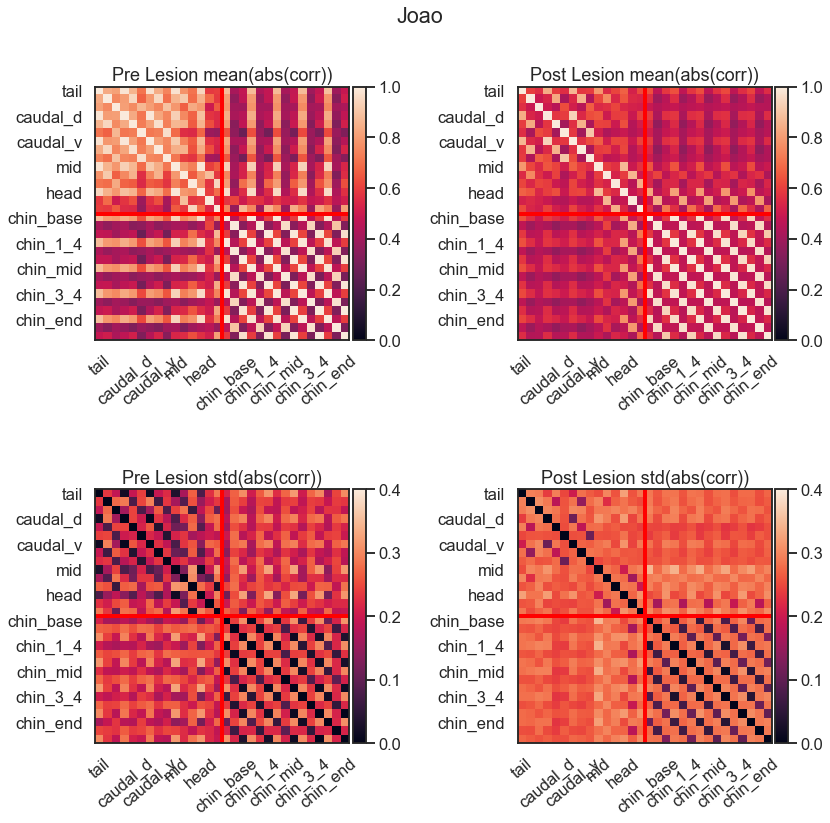

In [14]:
sns.set_style("white")
sns.set_context("talk")

fish_name = "Joao"
fig, ax = plt.subplots(2,2, figsize = (12,12))
im = ax[0,0].imshow(np.nanmean(np.abs(corr_dict[fish_name]["pre"]), -1), vmin=0, vmax=1)
ax[0,0].set_title('Pre Lesion mean(abs(corr))')
im1 = ax[0,1].imshow(np.nanmean(np.abs(corr_dict[fish_name]["post"]), -1), vmin=0, vmax=1)
ax[0,1].set_title('Post Lesion mean(abs(corr))')
im2 = ax[1,0].imshow(np.nanstd(np.abs(corr_dict[fish_name]["pre"]), -1), vmin=0, vmax=.4)
ax[1,0].set_title('Pre Lesion std(abs(corr))')
im3 = ax[1,1].imshow(np.nanstd(np.abs(corr_dict[fish_name]["post"]), -1), vmin=0, vmax=.4)
ax[1,1].set_title('Post Lesion std(abs(corr))')

ax = ax.flatten()
ims = [im, im1, im2, im3]
for i, curr_ax in enumerate(ax):
    divider = make_axes_locatable(curr_ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    curr_ax.set_xticks(ticks = np.arange(0, 30, 3));
    curr_ax.set_xticklabels(labels =  col_order, rotation=40)
    curr_ax.set_yticks(ticks = np.arange(0, 30, 3));
    curr_ax.set_yticklabels(labels =  col_order)
    #rect = patches.Rectangle((15-1.5,15-1.5), 15+1, 15+1, color = 'red', fill=False, linewidth=4)
    #curr_ax.add_patch(rect)
    curr_ax.plot([0-.5, 30-1+.5], [15-.5, 15-.5], linewidth=4, color='red')
    curr_ax.plot([15-.5, 15-.5], [0-.5, 30-1+.5], linewidth=4, color='red')
    fig.colorbar(ims[i], cax=cax, orientation='vertical')
    
fig.suptitle(fish_name)
fig.tight_layout()
plt.savefig('first_pass_corrs_%s.png' % fish_name)


idea --> fit a linear model from all bodyparts other than the chin, to all bodyparts including the chin. do it per trial. look at the matrices.

### want:
* for every trial, predict chin using non-chin, save coeffs, compute r squared, and save. 
## Thoughts:
* we compare between two sets of vectors in MV stats
* here' specifically, we're interested in correlations between chin and rest of body, and how they change in each condition.
* stats: compute some covariance or correlation matrix per trial
* then, compute a correlation between a pair of matrices (RV coeff)
* then do hypothesis testing on the RV coeff

In [164]:
body_part_for_kinematics = "mid"
center_coords = True
if center_coords:
    fit_intercept = False
fish_names = list(data_dict["trials"].keys())
cond_names = list(data_dict["trials"]["Joao"].keys())
beta_dict = make_empty_hierarchical_dict(fish_names, cond_names)
r_squared_dict = make_empty_hierarchical_dict(fish_names, cond_names)
rv_dict = make_empty_hierarchical_dict(fish_names, cond_names)
speed_dict = make_empty_hierarchical_dict(fish_names, cond_names)
accel_dict = make_empty_hierarchical_dict(fish_names, cond_names)
pca_dict = make_empty_hierarchical_dict(fish_names, cond_names)
fft_dict = make_empty_hierarchical_dict(fish_names, cond_names)
n_for_fft = 600

for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        #beta_dict[fish][cond] = np.zeros((15, 15, len(data_dict["trials"][fish][cond])))
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):
            curr_dframe = select_columns(trial_dframe)
            if center_coords:
                curr_dframe -= curr_dframe.mean()
            curr_dframe = curr_dframe[col_order] # re-order columns to emphasize chin pos
            inputs = curr_dframe.iloc[:, :15].to_numpy() # body coords
            outputs = curr_dframe.iloc[:, 15:].to_numpy() # chin coords
            reg = LinearRegression(fit_intercept=fit_intercept).fit(inputs,outputs) # the intercept is helpful for better preds
            r_squared = reg.score(inputs, outputs)
            rv = compute_RV_coef(inputs, outputs)
            pca_model = PCA(svd_solver="full")
            pca_model.fit(curr_dframe)
            fft = np.fft.fft(curr_dframe, axis=0, n=n_for_fft) # uses 600 first time points, or pads 
            # save
            r_squared_dict[fish][cond].append(r_squared)
            rv_dict[fish][cond].append(rv[0,1]) # body-chin entry of the matrix.
            beta_dict[fish][cond].append(reg.coef_)
            speed_dict[fish][cond].append(compute_speed(curr_dframe[body_part_for_kinematics], 300).mean().mean())
            accel_dict[fish][cond].append(compute_accel(curr_dframe[body_part_for_kinematics], 300).mean().mean())
            pca_dict[fish][cond].append(pca_model.explained_variance_ratio_)
            fft_dict[fish][cond].append(fft)

In [20]:
accel_dframe = fish_dict_to_dframe(accel_dict)

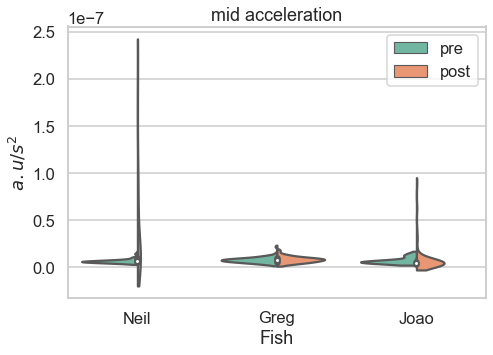

In [21]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize = (7.5,5))
sns.violinplot(x="Fish", y="Variable", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=accel_dframe, z_order=1)
plt.title("%s acceleration" % body_part_for_kinematics);
plt.ylabel(r'$a.u/s^2$');
plt.legend(loc = "upper right")
plt.savefig('%s_accel.png' % body_part_for_kinematics)

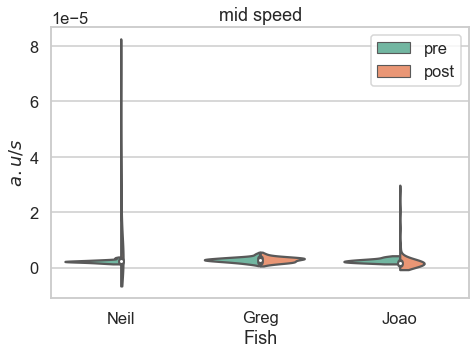

In [22]:
speed_dframe = fish_dict_to_dframe(speed_dict)
plt.figure(figsize = (7.5,5))
sns.set_style("whitegrid")
sns.set_context("talk")
sns.violinplot(x="Fish", y="Variable", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=speed_dframe, z_order=1)
plt.title("%s speed" % body_part_for_kinematics);
plt.ylabel(r'$a.u/s$');
plt.legend(loc = "upper right")
plt.savefig('%s_speed.png' % body_part_for_kinematics)

In [23]:
rv_dframe = fish_dict_to_dframe(rv_dict)
rv_dframe

,Fish,Lesion,Variable
0,Neil,pre,0.838141
1,Neil,pre,0.813645
2,Neil,pre,0.507686
3,Neil,pre,0.661025
4,Neil,pre,0.382948
...,...,...,...
265,Joao,post,0.978599
266,Joao,post,0.853102
267,Joao,post,0.915154
268,Joao,post,0.912040


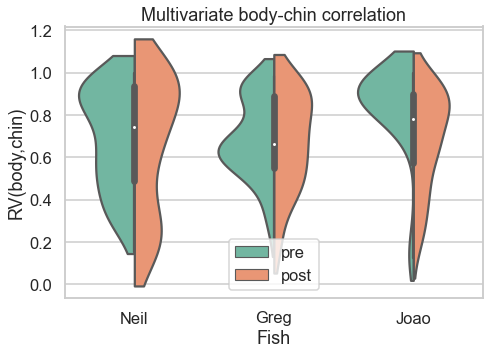

In [24]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize = (7.5,5))
sns.violinplot(x="Fish", y="Variable", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=rv_dframe, z_order=1)
plt.title("Multivariate body-chin correlation");
plt.ylabel("RV(body,chin)");
plt.legend(loc = "lower center")
plt.savefig('RV.png' )

In [25]:
# want: column called name, column called condition, and column called r_squared
dframe_dict = pd.DataFrame(columns= ["Fish", "Lesion", "r_squared"])

dframe_dict.head()
for i, fish in enumerate(r_squared_dict.keys()):
    for j, cond in enumerate(r_squared_dict[fish].keys()):
        for k, r_sq in enumerate(r_squared_dict[fish][cond]):
            dframe_dict = dframe_dict.append({"Fish": fish, 
                            "Lesion": cond, 
                            "r_squared": r_sq}, ignore_index=True)
assert(np.max(dframe_dict["r_squared"])<1.0)

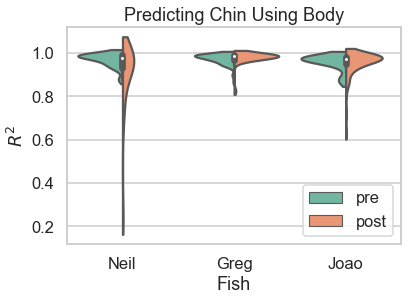

In [26]:
sns.set_style("whitegrid")
sns.set_context("talk")
sns.violinplot(x="Fish", y="r_squared", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=dframe_dict, z_order=1)
plt.title("Predicting Chin Using Body");
plt.ylabel(r'$R^2$');
plt.legend(loc = "lower right")
plt.savefig('r_squared.png')

## PCA analysis
hoe complicated is the movement? how many PCs are required to model it?

In [17]:
from sklearn.decomposition import PCA

In [29]:

curr_dframe.shape

(1261, 30)

In [18]:
pca_model = PCA(svd_solver="full")

In [19]:
pca_model.fit(curr_dframe)

PCA(svd_solver='full')

<AxesSubplot:title={'center':'PCA participation ratio'}, xlabel='# components', ylabel='frac. explained var.'>

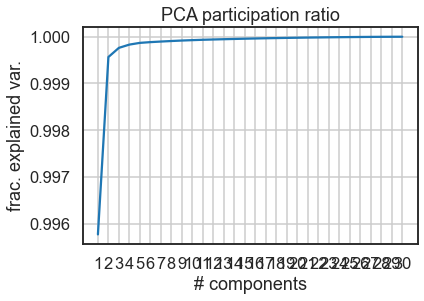

In [21]:
fig, ax = plt.subplots(1,1)
plot_participation_ratio(pca_object=pca_model, ax=ax)

In [32]:
# loop over fish
# loop over cond
# compute cumsum, mean and stderr
# plot
arr = np.array([[0., 2., 4.], [1., 4., 6]])
cum = np.cumsum(arr, axis=1)
print(cum.shape)
mean = np.mean(cum, axis=0)
print(mean.shape)

(2, 3)
(3,)


In [24]:
len(pca_dict["Joao"]["post"])

94

In [25]:
cond_arr = np.asarray(pca_dict["Joao"]["post"])
np.cumsum(cond_arr)

(94, 30)

In [34]:
mean_summary = make_empty_hierarchical_dict(fish_names, cond_names)
std_summary = make_empty_hierarchical_dict(fish_names, cond_names)
for i, fish in enumerate(pca_dict.keys()):
    print("Fish: %s" % fish)
    for j, cond in enumerate(pca_dict[fish].keys()):
        print("Condition: %s" % cond)
        cond_arr = np.cumsum(np.asarray(pca_dict[fish][cond]), axis=1)
        mean_summary[fish][cond] = np.mean(cond_arr, axis=0)
        std_summary[fish][cond] = np.std(cond_arr, axis=0)/np.sqrt(cond_arr.shape[0])

Fish: Neil
Condition: pre
Condition: post
Fish: Greg
Condition: pre
Condition: post
Fish: Joao
Condition: pre
Condition: post


In [36]:
mean_summary[fish][cond].shape

(30,)

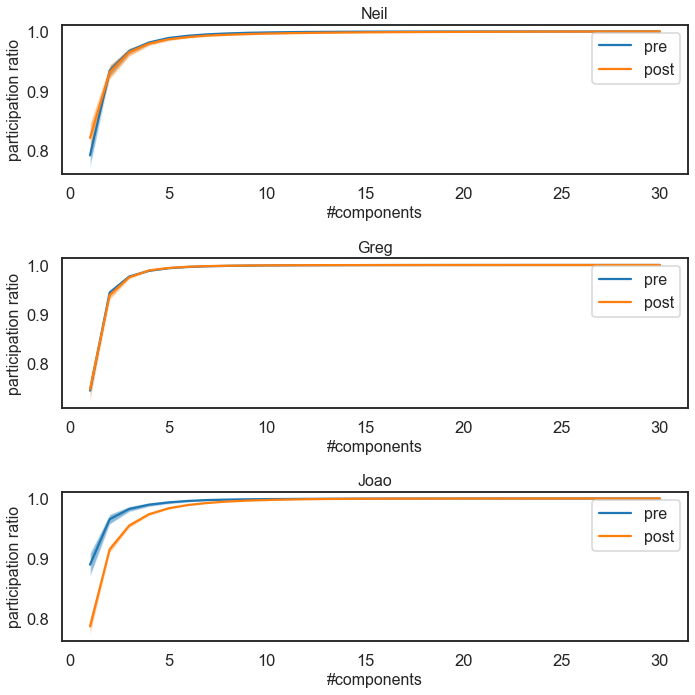

In [51]:
num_comps_to_plot = 30 + 1
fig, ax = plt.subplots(len(fish_names), 1, figsize = (10, 10))
for i, fish in enumerate(mean_summary.keys()):
    for j, cond in enumerate(mean_summary[fish].keys()):
        ax[i].plot(np.arange(1, mean_summary[fish][cond].shape[0]+1)[:num_comps_to_plot], mean_summary[fish][cond][:num_comps_to_plot], label = cond);
        ax[i].fill_between(np.arange(1, mean_summary[fish][cond].shape[0]+1)[:num_comps_to_plot], (mean_summary[fish][cond] - std_summary[fish][cond])[:num_comps_to_plot], 
                           (mean_summary[fish][cond] + std_summary[fish][cond])[:num_comps_to_plot], alpha=0.5)
    ax[i].set_title(fish, fontsize=16)
    ax[i].set_xlabel('#components', fontsize=16)
    ax[i].set_ylabel('participation ratio',  fontsize=16)
    ax[i].legend(fontsize=16)
fig.tight_layout()
plt.savefig('participation_ratio.png')

## Overall differences from a line. 
review the body parts and their positions, make sure we have everything we need.

## Spectral analysis
Run FFT on all body parts per trial. use a predefined frequency band. summarize powers in different bands, and compare across trials. 

In [53]:
test_sig = np.random.normal(size = 100)

In [55]:
fft = np.fft.fft(test_sig)

In [62]:
test_trial = data_dict["trials"]["Joao"]["pre"][3]
curr_dframe = select_columns(trial_dframe)
fft = np.fft.fft(curr_dframe)
fft.shape

(1261, 30)

In [56]:
N = test_sig.shape[0]
dt = 0.01
omega_range = np.linspace(0, 1 / dt, N)

Text(0.5, 0.98, 'Input Spectrum')

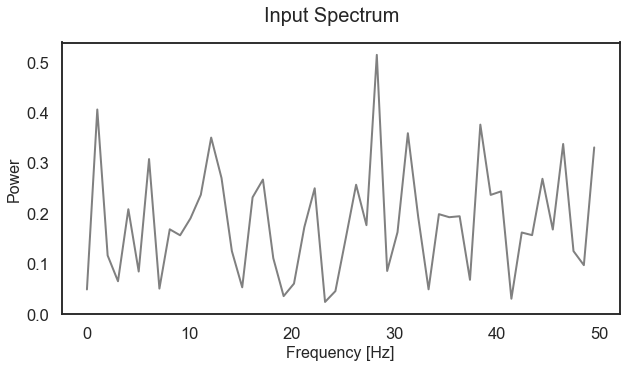

In [57]:
plt.figure(figsize=(10,5))
plt.ylabel("Power", fontsize = 16) # amplitude -> normalize by 1/n. power -> 2/n
plt.xlabel("Frequency [Hz]", fontsize = 16)
#plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.plot(omega_range[:N//2], np.abs(fft)[:N // 2]*2/N, color = "gray", linewidth = 2)
plt.suptitle("Input Spectrum", fontsize = 20)

In [117]:
nat_freq = .5
T = 2
dt = 1./300.
N = int(T/dt) # n time points
t = dt*np.arange(N) # time points in "real time"
test_input = np.sin(2*np.pi*nat_freq*t)
test_input = np.tile(test_input, (5,1)).T
test_input.shape

(600, 5)

In [118]:
# test_input = np.tile(np.arange(8), (5,1))
# test_input.shape

In [119]:
fft = np.fft.fft(test_input, axis=0)

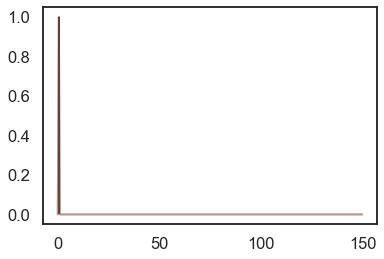

In [125]:
omega_range = np.linspace(0, 1 / dt, N)
plt.plot(omega_range[:N//2],np.abs(fft)[:N // 2]*2/N, linewidth = 2, alpha = 0.2)
plt.vlines(x = nat_freq, ymin = 0, ymax = 1, color = "black", linewidth = 2)

so we should ensure using `np.fft.fft(axis=0)`

In [127]:
trial_lengths_dict = make_empty_hierarchical_dict(fish_names, cond_names)
for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        #beta_dict[fish][cond] = np.zeros((15, 15, len(data_dict["trials"][fish][cond])))
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):
            trial_lengths_dict[fish][cond].append(trial_dframe.shape[0])

Text(0.5, 1.0, 'Frames in a trial')

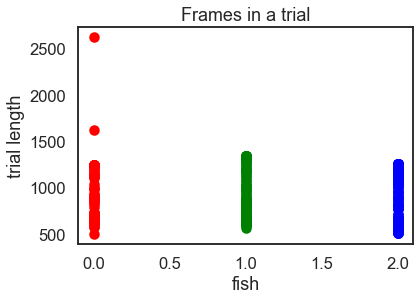

In [136]:
color_list = ['r', 'g', 'b']
for i, fish in enumerate(trial_lengths_dict.keys()):
    for j, cond in enumerate(trial_lengths_dict[fish].keys()):
        plt.scatter(i*np.ones(len(trial_lengths_dict[fish][cond])), 
                    trial_lengths_dict[fish][cond], color = color_list[i])
plt.xlabel('fish')
plt.ylabel('trial length')
plt.title('Frames in a trial')

In [165]:
fft_cond_arr = np.asarray(fft_dict["Joao"]["post"]) 
fft_cond_arr.shape

(94, 600, 30)

In [161]:
fft = np.fft.fft(curr_dframe, n=600, axis=0)

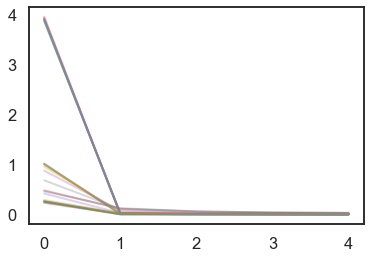

In [163]:
plt.plot(np.abs(fft)[:5, :]*2/N, linewidth = 2, alpha = 0.3);

In [176]:
mean_summary = make_empty_hierarchical_dict(fish_names, cond_names)
std_summary = make_empty_hierarchical_dict(fish_names, cond_names)
for i, fish in enumerate(pca_dict.keys()):
    print("Fish: %s" % fish)
    for j, cond in enumerate(pca_dict[fish].keys()):
        print("Condition: %s" % cond)
        fft_cond_arr = np.abs(np.asarray(fft_dict[fish][cond])[:, :n_for_fft//2,:]*2/n_for_fft)
        mean_summary[fish][cond] = np.mean(fft_cond_arr, axis=0)
        std_summary[fish][cond] = np.std(fft_cond_arr, axis=0)/np.sqrt(cond_arr.shape[0])

Fish: Neil
Condition: pre
Condition: post
Fish: Greg
Condition: pre
Condition: post
Fish: Joao
Condition: pre
Condition: post


In [189]:
repeated_cols = np.repeat(col_order,3)
repeated_coords = np.tile(['x', 'y', 'z'], len(col_order))
print(repeated_cols)
print(repeated_coords)

['tail' 'tail' 'tail' 'caudal_d' 'caudal_d' 'caudal_d' 'caudal_v'
 'caudal_v' 'caudal_v' 'mid' 'mid' 'mid' 'head' 'head' 'head' 'chin_base'
 'chin_base' 'chin_base' 'chin_1_4' 'chin_1_4' 'chin_1_4' 'chin_mid'
 'chin_mid' 'chin_mid' 'chin_3_4' 'chin_3_4' 'chin_3_4' 'chin_end'
 'chin_end' 'chin_end']
['x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z'
 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z']


In [223]:
fft_plotting_folder = set_or_open_folder('../figs/fft')
num_comps_to_plot = 20 + 1
color_list = ['blue', 'red']
bodypart_idx = 6
omega_range = np.linspace(0, 1 / dt, n_for_fft)
for bodypart_idx in range(mean_summary[fish][cond].shape[1]):
    fig, ax = plt.subplots(len(fish_names), 1, figsize = (10, 10))
    for i, fish in enumerate(mean_summary.keys()):
        for j, cond in enumerate(mean_summary[fish].keys()):
            ax[i].errorbar(x = omega_range[:num_comps_to_plot], 
                           y = mean_summary[fish][cond][:, bodypart_idx][:num_comps_to_plot], 
                          yerr = std_summary[fish][cond][:, bodypart_idx][:num_comps_to_plot],
                           label = cond, color = color_list[j], marker = 'o', markersize = 5)
#             ax[i].plot(omega_range[:num_comps_to_plot], mean_summary[fish][cond][:, bodypart_idx][:num_comps_to_plot], label = cond, color = color_list[j], marker = 'o', markersize = 6);
#             ax[i].fill_between(omega_range[:num_comps_to_plot], (mean_summary[fish][cond][:, bodypart_idx] - std_summary[fish][cond][:, bodypart_idx])[:num_comps_to_plot], 
#                                (mean_summary[fish][cond][:, bodypart_idx] + std_summary[fish][cond][:, bodypart_idx])[:num_comps_to_plot], alpha=0.5)
        ax[i].set_title(fish, fontsize=16)
        ax[i].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[i].set_ylabel("Power",  fontsize=16)
        ax[i].legend(fontsize=16)
        ax[i].set_ylim([0,.30])
        plt.ylabel("Power", fontsize = 16) # amplitude -> normalize by 1/n. power -> 2/n
    fig.suptitle('FFT: {}({})'.format(repeated_cols[bodypart_idx], repeated_coords[bodypart_idx]))
    fig.tight_layout()
    plt.savefig(os.path.join(fft_plotting_folder, repeated_cols[bodypart_idx]+ '_'+ repeated_coords[bodypart_idx] + '_' 'fft.png'))
    fig.clf()

The folder already exists at: ../figs/fft


<ipython-input-223-f90608b24ad6>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(len(fish_names), 1, figsize = (10, 10))


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

['tail' 'tail' 'tail' 'caudal_d' 'caudal_d' 'caudal_d' 'caudal_v'
 'caudal_v' 'caudal_v' 'mid' 'mid' 'mid' 'head' 'head' 'head' 'chin_base'
 'chin_base' 'chin_base' 'chin_1_4' 'chin_1_4' 'chin_1_4' 'chin_mid'
 'chin_mid' 'chin_mid' 'chin_3_4' 'chin_3_4' 'chin_3_4' 'chin_end'
 'chin_end' 'chin_end']
['x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z'
 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z' 'x' 'y' 'z']


In [194]:
omega_range

array([  0.        ,   0.50083472,   1.00166945,   1.50250417,
         2.0033389 ,   2.50417362,   3.00500835,   3.50584307,
         4.0066778 ,   4.50751252,   5.00834725,   5.50918197,
         6.01001669,   6.51085142,   7.01168614,   7.51252087,
         8.01335559,   8.51419032,   9.01502504,   9.51585977,
        10.01669449,  10.51752922,  11.01836394,  11.51919866,
        12.02003339,  12.52086811,  13.02170284,  13.52253756,
        14.02337229,  14.52420701,  15.02504174,  15.52587646,
        16.02671119,  16.52754591,  17.02838063,  17.52921536,
        18.03005008,  18.53088481,  19.03171953,  19.53255426,
        20.03338898,  20.53422371,  21.03505843,  21.53589316,
        22.03672788,  22.5375626 ,  23.03839733,  23.53923205,
        24.04006678,  24.5409015 ,  25.04173623,  25.54257095,
        26.04340568,  26.5442404 ,  27.04507513,  27.54590985,
        28.04674457,  28.5475793 ,  29.04841402,  29.54924875,
        30.05008347,  30.5509182 ,  31.05175292,  31.55

AttributeError: 'Line2D' object has no property 'y_err'

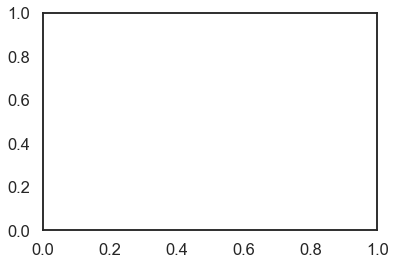

In [204]:
plt.errorbar(x = omega_range[:num_comps_to_plot], 
                           y = mean_summary[fish][cond][:, bodypart_idx][:num_comps_to_plot], 
                          y_err = std_summary[fish][cond][:, bodypart_idx][:num_comps_to_plot])

In [207]:
std_summary[fish][cond][:, bodypart_idx][:num_comps_to_plot].shape

(21,)